In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import os
import time
import pickle as pkl
import datetime

In [2]:
# Import and initialize Mountain Car Environment
# if render, uncomment
# env = gym.make('MountainCar-v0', render_mode = "human")

env = gym.make('MountainCar-v0')
np.random.seed(458)


In [3]:
# function for choosing action based on an epsilon greedy strategy
def chooseAction(pos, vel, q_table, epsilon):
    
    if np.random.random() < epsilon: # explore
        action = np.random.randint(0, env.action_space.n)
    else: # exploit
        action = np.argmax(q_table[pos][vel])

    return action

In [4]:
# function for state discretization
def getState(pos, env):
    
    newstate = (pos - env.observation_space.low)*np.array([10, 100])
    newstate = np.round(newstate, 0).astype(int)

    return newstate

### Q-Learning

In [187]:
# Define Q-learning function
def QLearning(env, learning, discount, epsilon, min_eps, episodes):

     # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()

    #writing to file
    path = f'./QLearning_data/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with Q-Learning on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()
            steps +=1    

            # Determine next action - epsilon greedy strategy
            action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

            # Get next state and reward
            state2, reward, done, info = env.step(action)[0:4] 
            
            # Discretize state2
            state2_adj = getState(state2, env)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps:
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj

            if steps >= 500:
                break
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards and steps
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        


        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
        if (episode+1) % 100 == 0:    # prints out average reward every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
                 
    
    env.close()

    # more writing
    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./QLearning_data/{timestamp}/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./QLearning_data/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [40]:
# Run Q-learning algorithm
avg_rewards, rewards,  avg_fin_steps, Q_table= QLearning(env, 0.2, 0.9, 0.8, 0, 100)
# print(avg_rewards, rewards, Q_table)

In [ ]:
avg_rewards2, rewards2, avg_fin_steps2 ,Q_table2 = QLearning(env, 0.2, 0.9, 0.8, 0, 2000)

Text(0.5, 1.0, 'Average Reward vs Episodes')

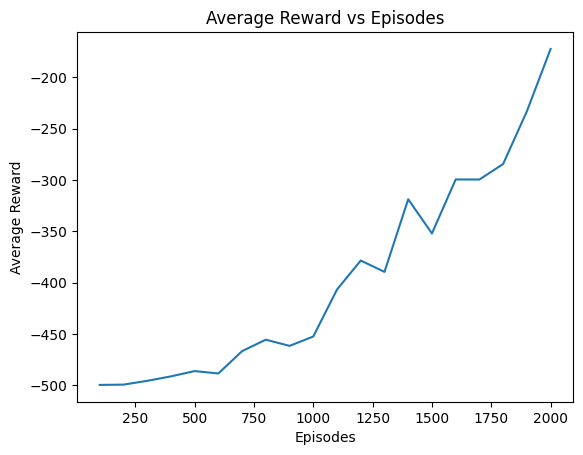

In [44]:
# Plot Average Rewards for Q-Learning
plt.plot(100*(np.arange(len(avg_rewards2)) + 1), avg_rewards2)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

Text(0.5, 1.0, 'Reward vs Episodes')

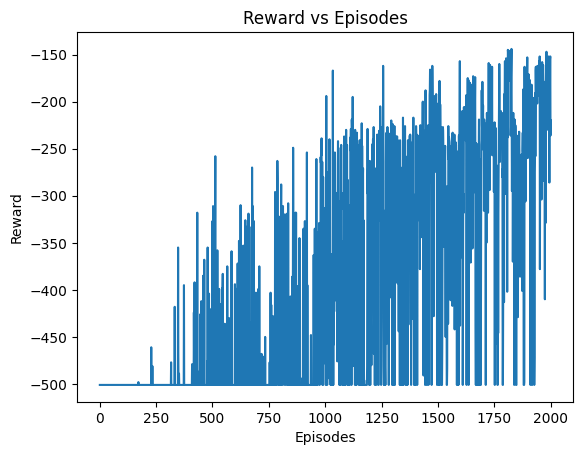

In [161]:
# Plot Rewards
plt.plot((np.arange(len(rewards2)) + 1), rewards2)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs Episodes')

Text(0.5, 1.0, 'Average Finished Steps vs Episodes')

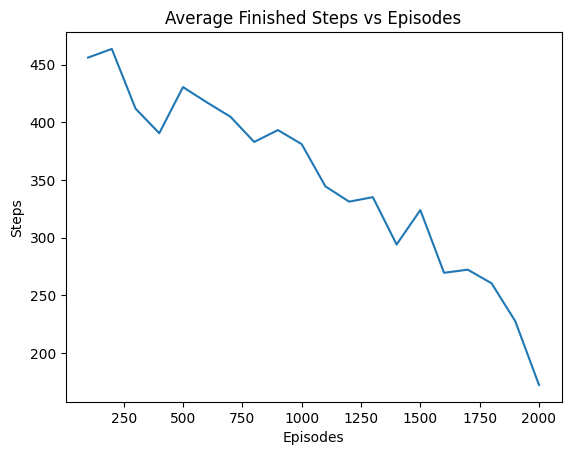

In [45]:
## Plot Average steps
plt.plot(100*(np.arange(len(avg_fin_steps2)) + 1), avg_fin_steps2)
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('Average Finished Steps vs Episodes')

Text(0.5, 1.0, 'Average Finished Steps vs Average Rewards')

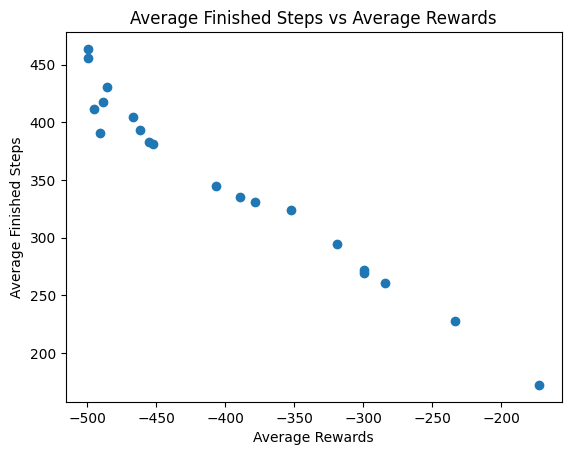

In [48]:
## both rewards and finished steps
plt.scatter(avg_rewards2, avg_fin_steps2)
plt.xlabel('Average Rewards')
plt.ylabel('Average Finished Steps')
plt.title('Average Finished Steps vs Average Rewards')

### SARSA 

In [188]:
# Define Sarsa function
def SARSA(env, learning, discount, epsilon, min_eps, episodes):

    # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()
    
    # writing to file
    path = f'./SARSA_data/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with SARSA on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run SARSA algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        # choose action based on state
        action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            steps +=1    

            # take next action and observe next state
            next_observation, reward, done, info = env.step(action)[0:4]
            state2 = getState(next_observation, env)

            # Get next action - epsilon greedy strategy
            next_action = chooseAction(state2[0], state2[1], Q, epsilon)

            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state2[0], state2[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps: #record best steps
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*(Q[state2[0], 
                                            state2[1],
                                            next_action]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2
            action = next_action
            if steps > 500:
                break
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
            
        if (episode+1) % 100 == 0:    # print average reward for every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
            
    env.close()

    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./SARSA_data/{timestamp}/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./SARSA_data/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards3, rewards3, avg_fin_steps3, Q_table3 = SARSA(env, 0.2, 0.9, 0.8, 0, 5000)

In [ ]:
avg_rewards4, rewards4, avg_fin_steps4, Q_table4 = SARSA(env, 0.2, 0.9, 0.8, 0, 2000)

Text(0.5, 1.0, 'Average Reward vs Episodes')

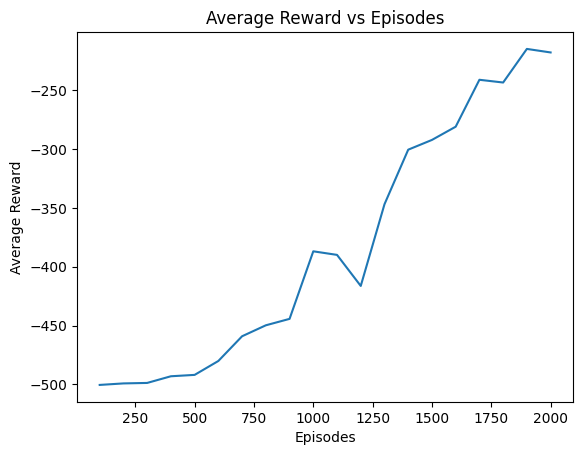

In [58]:
# Plot Average Rewards for SARSA
plt.plot(100*(np.arange(len(avg_rewards4)) + 1), avg_rewards4)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

Text(0.5, 1.0, 'Average Finished Steps vs Episodes')

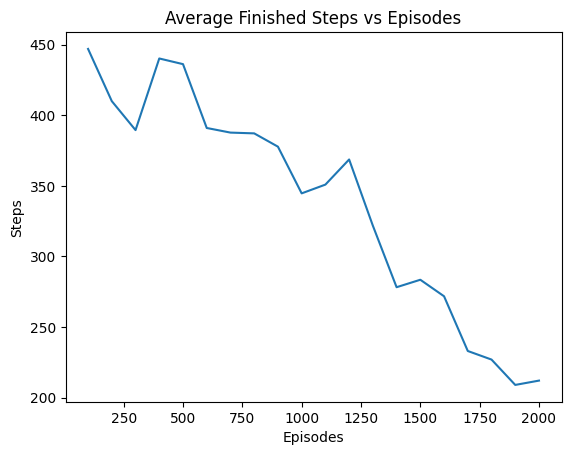

In [60]:
## Plot Average steps
plt.plot(100*(np.arange(len(avg_fin_steps4)) + 1), avg_fin_steps4)
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('Average Finished Steps vs Episodes')

Text(0.5, 1.0, 'Average Finished Steps vs Average Rewards')

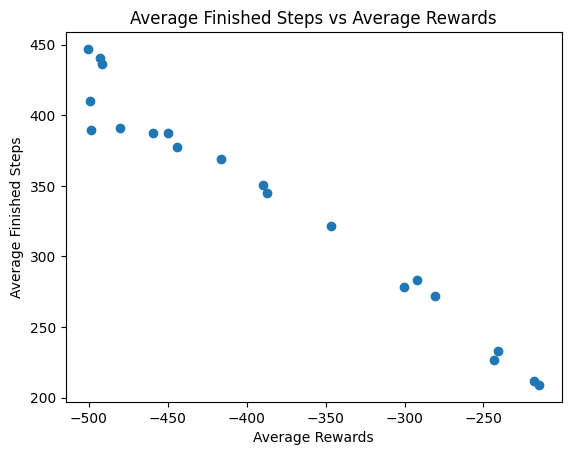

In [61]:
## both rewards and finished steps
plt.scatter(avg_rewards4, avg_fin_steps4)
plt.xlabel('Average Rewards')
plt.ylabel('Average Finished Steps')
plt.title('Average Finished Steps vs Average Rewards')

### plotting


In [ ]:
## Q learning for 1000
avg_rewardsQ1, rewardsQ1, avg_fin_stepsQ1, Q_tableQ1 = QLearning(env, 0.2, 0.9, 0.8, 0, 1000)

In [ ]:
## Q learning for 2000
avg_rewardsQ2, rewardsQ2, avg_fin_stepsQ2 ,Q_tableQ2 = QLearning(env, 0.2, 0.9, 0.8, 0, 2000)

In [ ]:
## Q learning for 5000
avg_rewardsQ5, rewardsQ5, avg_fin_stepsQ5, Q_tableQ5 = QLearning(env, 0.2, 0.9, 0.8, 0, 5000)

In [ ]:
## Q learning for 10000
avg_rewardsQ10, rewardsQ10, avg_fin_stepsQ10, Q_tableQ10 = QLearning(env, 0.2, 0.9, 0.8, 0, 10000)

In [ ]:
## Sarsa for 1000
avg_rewardsS1, rewardsS1, avg_fin_stepsS1, Q_tableS1 = SARSA(env, 0.2, 0.9, 0.8, 0, 1000)

In [ ]:
## Sarsa for 2000
avg_rewardsS2, rewardsS2, avg_fin_stepsS2, Q_tableS2 = SARSA(env, 0.2, 0.9, 0.8, 0, 2000)

In [ ]:
## Sarsa for 5000
avg_rewardsS5, rewardsS5, avg_fin_stepsS5, Q_tableS5 = SARSA(env, 0.2, 0.9, 0.8, 0, 5000)

In [ ]:
## Sarsa for 10000
avg_rewardsS10, rewardsS10, avg_fin_stepsS10, Q_tableS10 = SARSA(env, 0.2, 0.9, 0.8, 0, 10000)

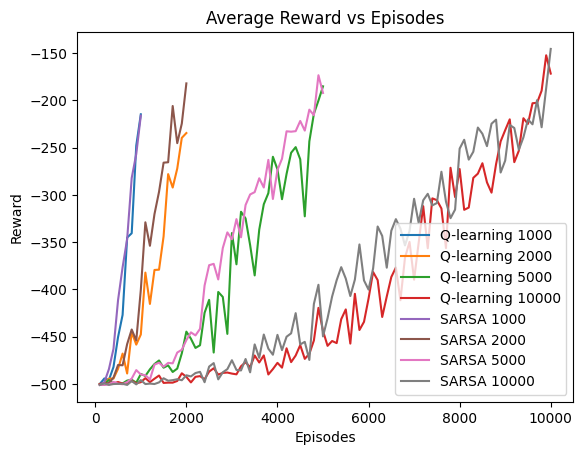

In [228]:
## Plotting Average Reward Comparison 
plt.plot(100*(np.arange(len(avg_rewardsQ1)) + 1), avg_rewardsQ1, label = 'Q-learning 1000')
plt.plot(100*(np.arange(len(avg_rewardsQ2)) + 1), avg_rewardsQ2, label = 'Q-learning 2000')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), avg_rewardsQ5, label = 'Q-learning 5000')
plt.plot(100*(np.arange(len(avg_rewardsQ10)) + 1), avg_rewardsQ10, label = 'Q-learning 10000')
plt.plot(100*(np.arange(len(avg_rewardsS1)) + 1), avg_rewardsS1, label = 'SARSA 1000')
plt.plot(100*(np.arange(len(avg_rewardsS2)) + 1), avg_rewardsS2, label = 'SARSA 2000')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), avg_rewardsS5, label = 'SARSA 5000')
plt.plot(100*(np.arange(len(avg_rewardsS10)) + 1), avg_rewardsS10, label = 'SARSA 10000')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig("Reward_comparison_original.jpg")

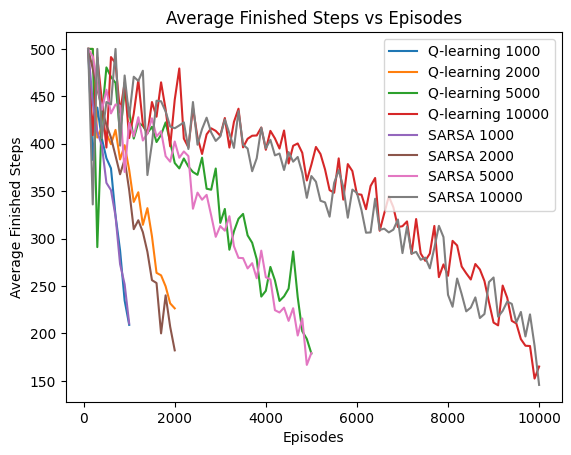

In [189]:
## Plotting Average Finished Comparison 
plt.plot(100*(np.arange(len(avg_fin_stepsQ1)) + 1), avg_fin_stepsQ1, label = 'Q-learning 1000')
plt.plot(100*(np.arange(len(avg_fin_stepsQ2)) + 1), avg_fin_stepsQ2, label = 'Q-learning 2000')
plt.plot(100*(np.arange(len(avg_fin_stepsQ5)) + 1), avg_fin_stepsQ5, label = 'Q-learning 5000')
plt.plot(100*(np.arange(len(avg_fin_stepsQ10)) + 1), avg_fin_stepsQ10, label = 'Q-learning 10000')
plt.plot(100*(np.arange(len(avg_fin_stepsS1)) + 1), avg_fin_stepsS1, label = 'SARSA 1000')
plt.plot(100*(np.arange(len(avg_fin_stepsS2)) + 1), avg_fin_stepsS2, label = 'SARSA 2000')
plt.plot(100*(np.arange(len(avg_fin_stepsS5)) + 1), avg_fin_stepsS5, label = 'SARSA 5000')
plt.plot(100*(np.arange(len(avg_fin_stepsS10)) + 1), avg_fin_stepsS10, label = 'SARSA 10000')
plt.xlabel('Episodes')
plt.ylabel('Average Finished Steps')
plt.title('Average Finished Steps vs Episodes')
plt.legend()

In [203]:
# Final Average Rewards
print(avg_rewardsQ1[-1])
print(avg_rewardsQ2[-1])
print(avg_rewardsQ5[-1])
print(avg_rewardsQ10[-1])
print(avg_rewardsS1[-1])
print(avg_rewardsS2[-1])
print(avg_rewardsS5[-1])
print(avg_rewardsS10[-1])

-214.82
-234.63
-185.23
-171.76
-216.21
-182.12
-192.25
-145.67


### Learning Rate


In [ ]:
learning_rates = np.arange(.05, 1.05, .05)
learning_rates = np.round(learning_rates,2)
lr_avg_rewards_list = []
lr_rewards_list = []
lr_fin_steps_list = []
for rate in learning_rates:
    avg_rewards, rewards, avg_fin_steps, Q_table = QLearning(env, rate, 0.9, 0.8, 0, 1000)
    lr_avg_rewards_list.append(avg_rewards)
    lr_rewards_list.append(rewards)
    lr_fin_steps_list.append(avg_fin_steps)

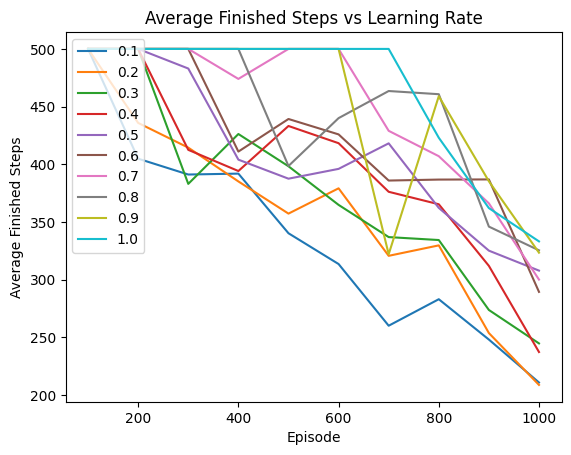

In [231]:
for i in np.arange(len(learning_rates)):
    if i %2 !=0:
        plt.plot(100*(np.arange(len(lr_fin_steps_list[i])) + 1) ,lr_fin_steps_list[i], label = str(learning_rates[i]))
plt.xlabel('Episode')
plt.ylabel('Average Finished Steps')
plt.title('Average Finished Steps vs Learning Rate')
plt.legend(loc = 'upper left')

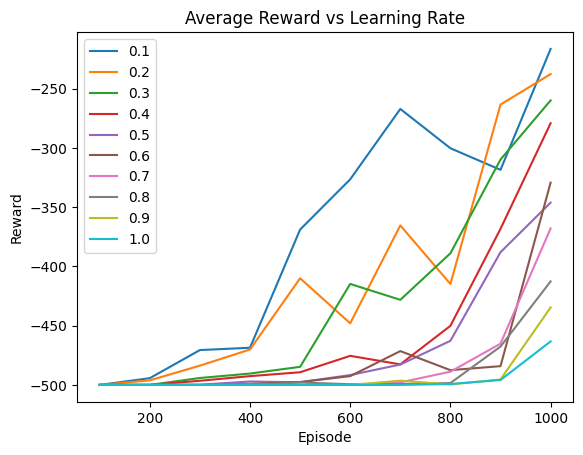

In [235]:
for i in np.arange(len(learning_rates)):
    if i %2 != 0:
        plt.plot(100*(np.arange(len(lr_avg_rewards_list[i])) + 1) ,lr_avg_rewards_list[i], label = str(learning_rates[i]))
# plt.plot(learning_rates, lr_avg_rewards_list, la)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward vs Learning Rate')
plt.legend(loc = 'upper left')
plt.savefig("learningrates")

### gamma (discount)

In [ ]:
discount_rates = np.linspace(.5, 1.0, 11)
discount_rates = np.round(discount_rates, 2)
# print(discount_rates)
d_avg_rewards_list = []
d_rewards_list = []
d_fin_steps_list = []
for rate in discount_rates:
    avg_rewards, rewards, avg_fin_steps, Q_table = QLearning(env, .2, rate, 0.8, 0, 1000)
    d_avg_rewards_list.append(avg_rewards)
    d_rewards_list.append(rewards)
    d_fin_steps_list.append(avg_fin_steps)

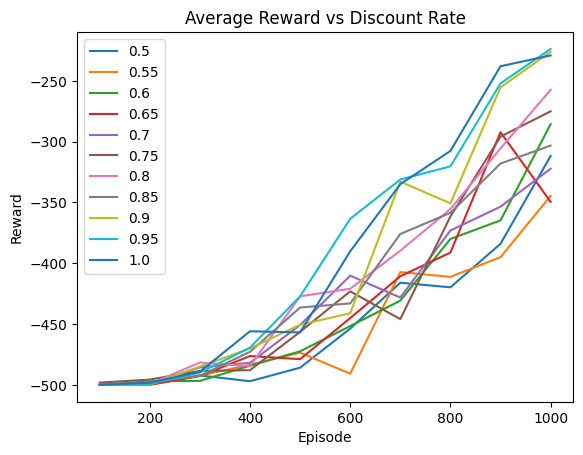

In [233]:
for i in np.arange(len(discount_rates)):
    # if i %2==0:
    plt.plot(100*(np.arange(len(d_avg_rewards_list[i])) + 1) ,d_avg_rewards_list[i], label = str(discount_rates[i]))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward vs Discount Rate')
plt.legend(loc = 'upper left')
plt.savefig("discountrates")

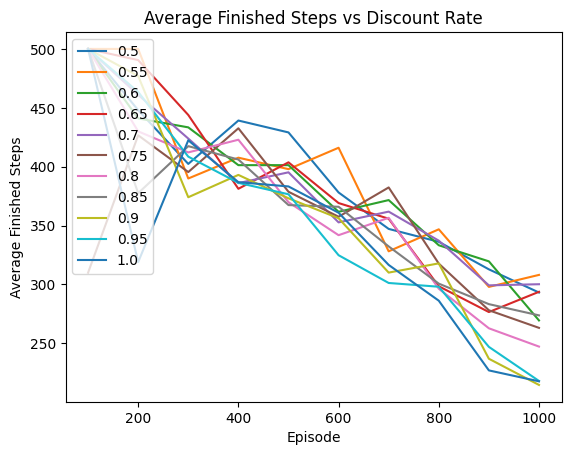

In [178]:
for i in np.arange(len(discount_rates)):
    plt.plot(100*(np.arange(len(d_fin_steps_list[i])) + 1) ,d_fin_steps_list[i], label = str(discount_rates[i]))
# plt.plot(learning_rates, lr_avg_rewards_list, la)
plt.xlabel('Episode')
plt.ylabel('Average Finished Steps')
plt.title('Average Finished Steps vs Discount Rate')
plt.legend(loc = 'upper left')

### Epsilon

In [ ]:
epsilons = np.linspace(.1, 1.0, 10)
epsilons = np.round(epsilons, 2)
e_avg_rewards_list = []
e_rewards_list = []
e_fin_steps_list = []
for rate in epsilons:
    avg_rewards, rewards, avg_fin_steps, Q_table = QLearning(env, .2, .9, rate, 0, 1000)
    e_avg_rewards_list.append(avg_rewards)
    e_rewards_list.append(rewards)
    e_fin_steps_list.append(avg_fin_steps)

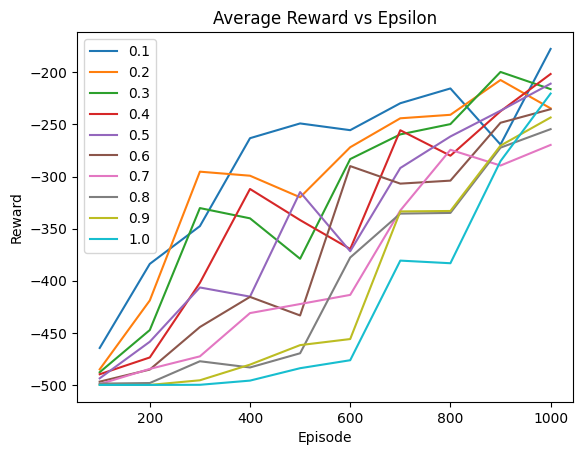

In [241]:
for i in np.arange(len(epsilons)):
    plt.plot(100*(np.arange(len(e_avg_rewards_list[i])) + 1) ,e_avg_rewards_list[i], label = str(epsilons[i]))
# plt.plot(learning_rates, lr_avg_rewards_list, la)
# for i in np.arange(len(epsilons2)):
#     plt.plot(100*(np.arange(len(e2_avg_rewards_list[i])) + 1) ,e2_avg_rewards_list[i], label = str(epsilons2[i]))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward vs Epsilon')
plt.legend(loc = 'upper left')
plt.savefig('epsilons')

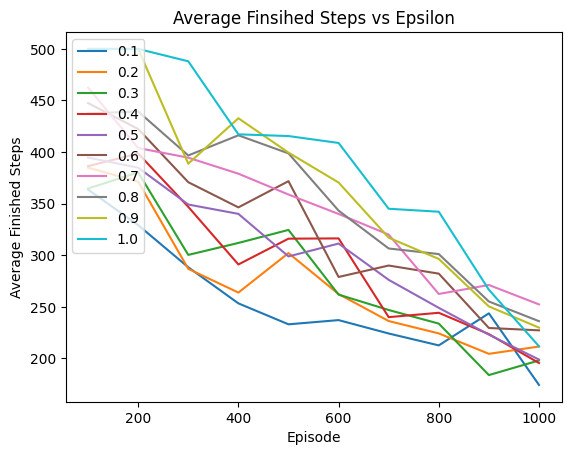

In [182]:
for i in np.arange(len(epsilons)):
    plt.plot(100*(np.arange(len(e_fin_steps_list[i])) + 1) ,e_fin_steps_list[i], label = str(epsilons[i]))
# plt.plot(learning_rates, lr_avg_rewards_list, la)
plt.xlabel('Episode')
plt.ylabel('Average Finished Steps')
plt.title('Average Finsihed Steps vs Epsilon')
plt.legend(loc = 'upper left')

In [ ]:
epsilons2 = np.linspace(.01, .1, 4)
# print(epsilons2)
e2_avg_rewards_list = []
e2_rewards_list = []
e2_fin_steps_list = []
for rate in epsilons:
    avg_rewards, rewards, avg_fin_steps, Q_table = QLearning(env, .2, .9, rate, 0, 1000)
    e2_avg_rewards_list.append(avg_rewards)
    e2_rewards_list.append(rewards)
    e2_fin_steps_list.append(avg_fin_steps)

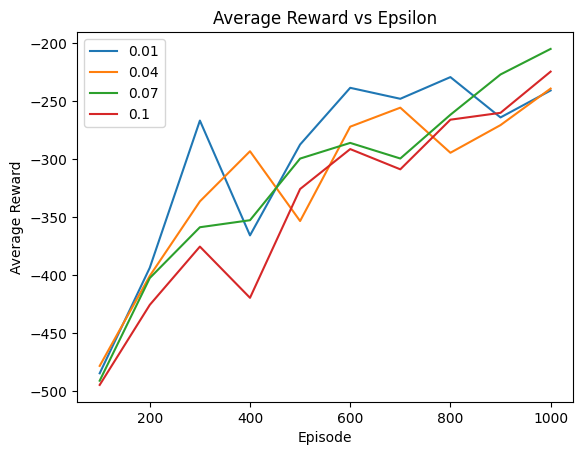

In [112]:
for i in np.arange(len(epsilons2)):
    plt.plot(100*(np.arange(len(e2_avg_rewards_list[i])) + 1) ,e2_avg_rewards_list[i], label = str(epsilons2[i]))
# plt.plot(learning_rates, lr_avg_rewards_list, la)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Epsilon')
plt.legend(loc = 'upper left')

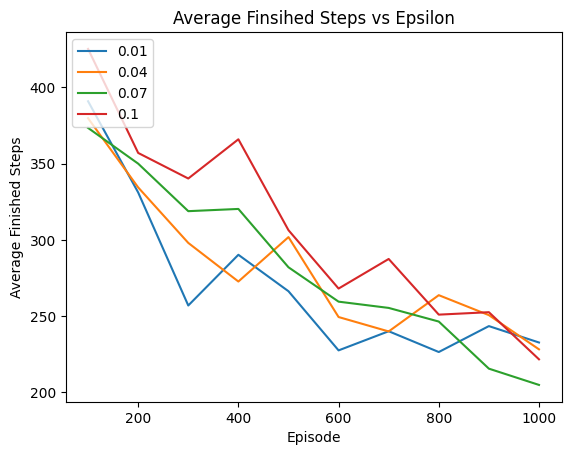

In [113]:
for i in np.arange(len(epsilons2)):
    plt.plot(100*(np.arange(len(e2_fin_steps_list[i])) + 1) ,e2_fin_steps_list[i], label = str(epsilons2[i]))
# plt.plot(learning_rates, lr_avg_rewards_list, la)
plt.xlabel('Episode')
plt.ylabel('Average Finished Steps')
plt.title('Average Finsihed Steps vs Epsilon')
plt.legend(loc = 'upper left')

## A different epsilon reduction 

#### Stalled epsilon

same constant epsilon for x number of steps

In [197]:
# Define Q-learning function
def QLearning_eps(env, learning, discount, epsilon, min_eps, episodes):

     # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()

    #writing to file
    path = f'./QLearning_data_eps/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with Q-Learning with different epsilon reduction on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()
            steps +=1    

            # Determine next action - epsilon greedy strategy
            action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

            # Get next state and reward
            state2, reward, done, info = env.step(action)[0:4] 
            
            # Discretize state2
            state2_adj = getState(state2, env)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps:
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj

            if steps >= 500:
                break
        
        # Decay epsilon
        if epsilon > min_eps and episode > 300:
            epsilon -= reduction
        
        # Track rewards and steps
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        

        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
        if (episode+1) % 100 == 0:    # prints out average reward every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
                 
    
    env.close()

    # more writing
    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./QLearning_data_eps/{timestamp}/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./QLearning_data_eps/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards, rewards, avg_fin_steps, Q_table = QLearning(env, .2, .9, 0.2, 0, 1000)

In [ ]:
avg_rewards_eps, rewards_eps, avg_fin_steps_eps, Q_table_eps = QLearning_eps(env, .2, .9, 0.2, 0, 5000)

#### Linear Epsilon Decay

In [195]:
# Q-learning with Linear Epsilon Decay

# Define Q-learning function
def QLearning_lin_eps(env, learning, discount, epsilon, min_eps, episodes):

     # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()

    #writing to file
    path = f'./QLearning_data_eps/{timestamp}_linear/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with Q-Learning with linear epsilon decay on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Training steps
    num_training_steps = 500
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/num_training_steps
    
    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()
            steps +=1    

            # Determine next action - epsilon greedy strategy
            action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

            # Get next state and reward
            state2, reward, done, info = env.step(action)[0:4] 
            
            # Discretize state2
            state2_adj = getState(state2, env)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps:
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj

            if steps >= num_training_steps:
                break
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards and steps
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        

        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
        if (episode+1) % 100 == 0:    # prints out average reward every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
                 
    
    env.close()

    # more writing
    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./QLearning_data_eps/{timestamp}_linear/log_linear_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./QLearning_data_eps/{timestamp}_linear/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_lineps, rewards_lineps, avg_fin_steps_lineps, Q_table_lineps = QLearning_lin_eps(env, .2, .9, 0.2, 0, 5000)

#### Exponential Decay

In [156]:
# Q-learning with Exponential Epsilon Decay

# Define Q-learning function
def QLearning_exp_eps(env, learning, discount, epsilon, min_eps, episodes):

     # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()

    #writing to file
    path = f'./QLearning_data_eps/{timestamp}_exponential/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with Q-Learning with exponential epsilon decay on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Training steps
    num_training_steps = 500
    
    # Initialize epsilon_end
    epsilon_end = 0.001
    # Calculate episodic reduction in epsilon
    decay = (epsilon_end/epsilon)**(1/num_training_steps)
    
    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()
            steps +=1    

            # Determine next action - epsilon greedy strategy
            action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

            # Get next state and reward
            state2, reward, done, info = env.step(action)[0:4] 
            
            # Discretize state2
            state2_adj = getState(state2, env)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps:
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj

            if steps >= num_training_steps:
                break
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon *= decay
        
        # Track rewards and steps
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        

        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
        if (episode+1) % 100 == 0:    # prints out average reward every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
                 
    
    env.close()

    # more writing
    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./QLearning_data_eps/{timestamp}_exponential/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./QLearning_data_eps/{timestamp}_exponential/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_expeps, rewards_expeps, avg_fin_steps_expeps, Q_table_expeps = QLearning_exp_eps(env, .2, .9, 0.2, 0, 5000)

#### Discrete Epsilon Decay

In [192]:
# Q-learning with Discrete Interval Decay

# Define Q-learning function
def QLearning_dis_eps(env, learning, discount, epsilon, min_eps, episodes):

     # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()

    #writing to file
    path = f'./QLearning_data_eps/{timestamp}_discrete/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with Q-Learning with discrete epsilon decay on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Training steps
    num_training_steps = 500

    # Calculate decay and interval
    decay = 0.005
    interval = 100

    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()
            steps +=1    

            # Determine next action - epsilon greedy strategy
            action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

            # Get next state and reward
            state2, reward, done, info = env.step(action)[0:4] 
            
            # Discretize state2
            state2_adj = getState(state2, env)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps:
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj

            if steps >= num_training_steps:
                break
        
        # Decay epsilon
        if episode % interval == 0 and epsilon > decay:
            epsilon -= decay
        
        # Track rewards and steps
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        

        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
        if (episode+1) % 100 == 0:    # prints out average reward every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
                 
    
    env.close()

    # more writing
    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./QLearning_data_eps/{timestamp}_discrete/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./QLearning_data_eps/{timestamp}_discrete/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_diseps, rewards_diseps, avg_fin_steps_diseps, Q_table_diseps = QLearning_dis_eps(env, .2, .9, 0.2, 0, 5000)

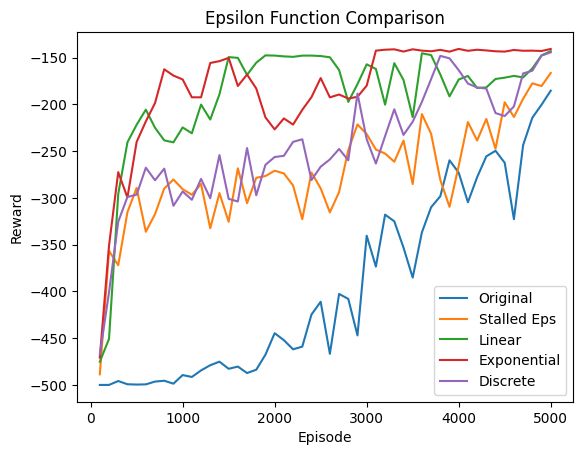

In [242]:
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), avg_rewardsQ5, label = 'Original')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1),avg_rewards_eps, label = 'Stalled Eps')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1),avg_rewards_lineps, label = 'Linear')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), avg_rewards_expeps, label = 'Exponential')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), avg_rewards_diseps, label = 'Discrete')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title("Epsilon Function Comparison")
plt.savefig("Avg_Rewards_Epsilons")

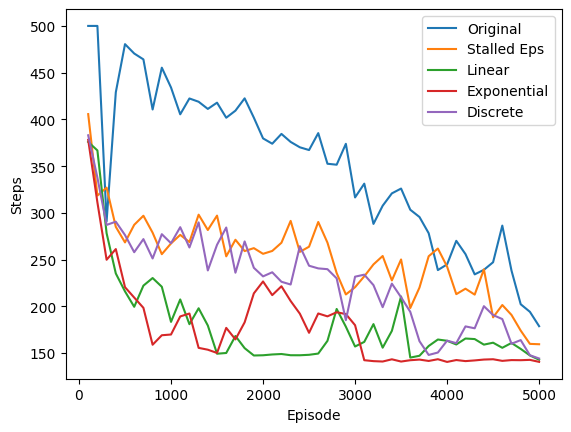

In [200]:
plt.plot(100*(np.arange(len(avg_fin_stepsQ5)) + 1), avg_fin_stepsQ5, label = 'Original')
plt.plot(100*(np.arange(len(avg_fin_stepsQ5)) + 1),avg_fin_steps_eps, label = 'Stalled Eps')
plt.plot(100*(np.arange(len(avg_fin_stepsQ5)) + 1),avg_fin_steps_lineps, label = 'Linear')
plt.plot(100*(np.arange(len(avg_fin_stepsQ5)) + 1), avg_fin_steps_expeps, label = 'Exponential')
plt.plot(100*(np.arange(len(avg_fin_stepsQ5)) + 1), avg_fin_steps_diseps, label = 'Discrete')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.legend()
plt.savefig("Avg_FinalSteps_Epsilons.jpg")

## SARSA epsilons

### Stalled epsilon 

In [204]:
# Define Sarsa function
def SARSA_stalled(env, learning, discount, epsilon, min_eps, episodes):

    # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()
    
    # writing to file
    path = f'./SARSA_epsdata/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with SARSA on {episodes} episodes with stalled epsilon:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run SARSA algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        # choose action based on state
        action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            steps +=1    

            # take next action and observe next state
            next_observation, reward, done, info = env.step(action)[0:4]
            state2 = getState(next_observation, env)

            # Get next action - epsilon greedy strategy
            next_action = chooseAction(state2[0], state2[1], Q, epsilon)

            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state2[0], state2[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps: #record best steps
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*(Q[state2[0], 
                                            state2[1],
                                            next_action]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2
            action = next_action
            if steps > 500:
                break
        
        # Decay epsilon
        if epsilon > min_eps and episode > 300:
            epsilon -= reduction
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
            
        if (episode+1) % 100 == 0:    # print average reward for every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
            
    env.close()

    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./SARSA_epsdata/{timestamp}/log_stalled_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./SARSA_epsdata/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_epsS, rewards_epsS, avg_fin_steps_epsS, Q_table_epsS = SARSA_stalled(env, .2, .9, 0.2, 0, 5000)

### Linear Epsilon

In [206]:
# Define Sarsa function
def SARSA_linear(env, learning, discount, epsilon, min_eps, episodes):

    # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()
    
    # writing to file
    path = f'./SARSA_epsdata/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with SARSA on {episodes} episodes with linear epsilon:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    num_training_steps = 500
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/num_training_steps
    
    # Run SARSA algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        # choose action based on state
        action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            steps +=1    

            # take next action and observe next state
            next_observation, reward, done, info = env.step(action)[0:4]
            state2 = getState(next_observation, env)

            # Get next action - epsilon greedy strategy
            next_action = chooseAction(state2[0], state2[1], Q, epsilon)

            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state2[0], state2[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps: #record best steps
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*(Q[state2[0], 
                                            state2[1],
                                            next_action]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2
            action = next_action
            if steps > num_training_steps:
                break
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
            
        if (episode+1) % 100 == 0:    # print average reward for every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
            
    env.close()

    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./SARSA_epsdata/{timestamp}/log_linear_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./SARSA_epsdata/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_linepsS, rewards_linepsS, avg_fin_steps_linepsS, Q_table_linepsS = SARSA_linear(env, .2, .9, 0.2, 0, 5000)

### Exponential Epsilon

In [208]:
# Define Sarsa function
def SARSA_exp(env, learning, discount, epsilon, min_eps, episodes):

    # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()
    
    # writing to file
    path = f'./SARSA_epsdata/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with SARSA on {episodes} episodes with exponential epsilon:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Training steps
    num_training_steps = 500
    
    # Initialize epsilon_end
    epsilon_end = 0.001
    # Calculate episodic reduction in epsilon
    decay = (epsilon_end/epsilon)**(1/num_training_steps)
    
    # Run SARSA algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        # choose action based on state
        action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            steps +=1    

            # take next action and observe next state
            next_observation, reward, done, info = env.step(action)[0:4]
            state2 = getState(next_observation, env)

            # Get next action - epsilon greedy strategy
            next_action = chooseAction(state2[0], state2[1], Q, epsilon)

            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state2[0], state2[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps: #record best steps
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*(Q[state2[0], 
                                            state2[1],
                                            next_action]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2
            action = next_action
            if steps > num_training_steps:
                break
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon *= decay
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
            
        if (episode+1) % 100 == 0:    # print average reward for every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
            
    env.close()

    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./SARSA_epsdata/{timestamp}/log_exponential_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./SARSA_epsdata/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_expepsS, rewards_expepsS, avg_fin_steps_expepsS, Q_table_expepsS = SARSA_exp(env, .2, .9, 0.2, 0, 5000)

### Discrete Epsilon

In [210]:
# Define Sarsa function
def SARSA_dis(env, learning, discount, epsilon, min_eps, episodes):

    # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()
    
    # writing to file
    path = f'./SARSA_epsdata/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with SARSA on {episodes} episodes with discrete interval epsilon:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    fin_ep_list = []
    fin_step_list = []
    ave_fin_step_list = []
    
    # Training steps
    num_training_steps = 500

    # Calculate decay and interval
    decay = 0.005
    interval = 100
    
    # Run SARSA algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        # choose action based on state
        action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            steps +=1    

            # take next action and observe next state
            next_observation, reward, done, info = env.step(action)[0:4]
            state2 = getState(next_observation, env)

            # Get next action - epsilon greedy strategy
            next_action = chooseAction(state2[0], state2[1], Q, epsilon)

            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state2[0], state2[1], action] = reward
                fin_ep_list.append(episode)
                fin_step_list.append(steps)
                if steps < best_steps: #record best steps
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*(Q[state2[0], 
                                            state2[1],
                                            next_action]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2
            action = next_action
            if steps > num_training_steps:
                break
        
        # Decay epsilon
        if episode % interval == 0 and epsilon > decay:
            epsilon -= decay
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

            if len(fin_step_list) ==0:
                ave_fin_step = 500
            else:
                ave_fin_step = np.mean(fin_step_list)
            ave_fin_step_list.append(ave_fin_step)
            fin_step_list = []
            
            
        if (episode+1) % 100 == 0:    # print average reward for every 100 ep
            print('Episode {} Average Reward: {} Average Finished Steps: {}'.format(episode+1, ave_reward, ave_fin_step))
            
    env.close()

    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./SARSA_epsdata/{timestamp}/log_discrete_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./SARSA_epsdata/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, ave_fin_step_list, Q 


In [ ]:
avg_rewards_disepsS, rewards_disepsS, avg_fin_steps_disepsS, Q_table_disepsS = SARSA_dis(env, .2, .9, 0.2, 0, 5000)

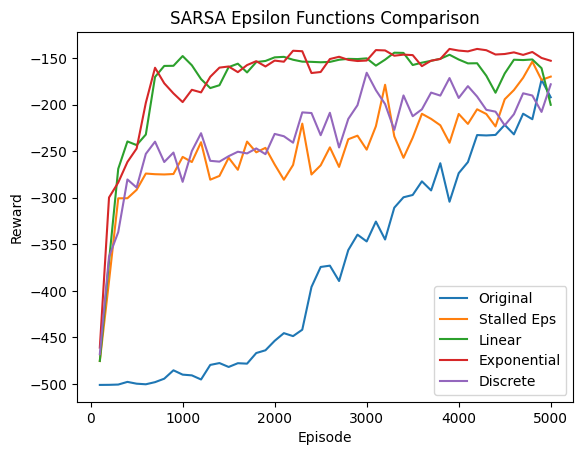

In [243]:
## PLOTTING
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), avg_rewardsS5, label = 'Original')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1),avg_rewards_epsS, label = 'Stalled Eps')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1),avg_rewards_linepsS, label = 'Linear')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), avg_rewards_expepsS, label = 'Exponential')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), avg_rewards_disepsS, label = 'Discrete')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title("SARSA Epsilon Functions Comparison")
plt.savefig("Avg_Rewards_Epsilons_SARSA")

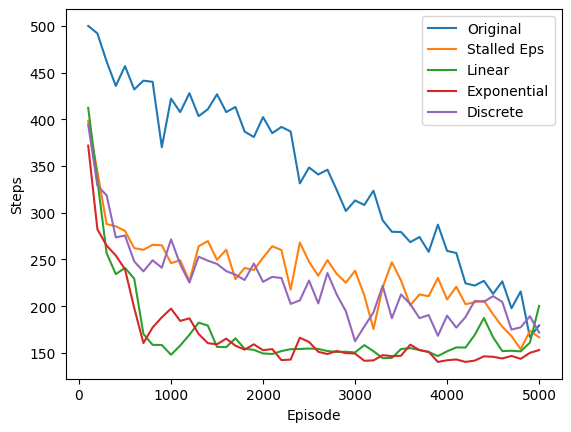

In [213]:
plt.plot(100*(np.arange(len(avg_fin_stepsS5)) + 1), avg_fin_stepsS5, label = 'Original')
plt.plot(100*(np.arange(len(avg_fin_stepsS5)) + 1),avg_fin_steps_epsS, label = 'Stalled Eps')
plt.plot(100*(np.arange(len(avg_fin_stepsS5)) + 1),avg_fin_steps_linepsS, label = 'Linear')
plt.plot(100*(np.arange(len(avg_fin_stepsS5)) + 1), avg_fin_steps_expepsS, label = 'Exponential')
plt.plot(100*(np.arange(len(avg_fin_stepsS5)) + 1), avg_fin_steps_disepsS, label = 'Discrete')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.legend()
plt.savefig("Avg_FinalSteps_Epsilons_SARSA.jpg")

## Possible best


In [214]:
best_lr = .1
best_gamma = 0.95
best_eps = .1

In [ ]:
best_avg_rewards_lineps, best_rewards_lineps, best_avg_fin_steps_lineps, best_Q_table_lineps = QLearning_lin_eps(env, best_lr, best_gamma, best_eps, 0, 5000)

In [ ]:
best_avg_rewards_linepsS, best_rewards_linepsS, best_avg_fin_steps_linepsS, best_Q_table_linepsS = SARSA_linear(env, best_lr, best_gamma, best_eps, 0, 5000)

In [ ]:
best_avg_rewards_expeps, best_rewards_expeps, best_avg_fin_steps_expeps, best_Q_table_expeps = QLearning_exp_eps(env, best_lr, best_gamma, best_eps, 0, 5000)

In [ ]:
best_avg_rewards_expepsS, best_rewards_expepsS, best_avg_fin_steps_expepsS, best_Q_table_expepsS = SARSA_exp(env, best_lr, best_gamma, best_eps, 0, 5000)

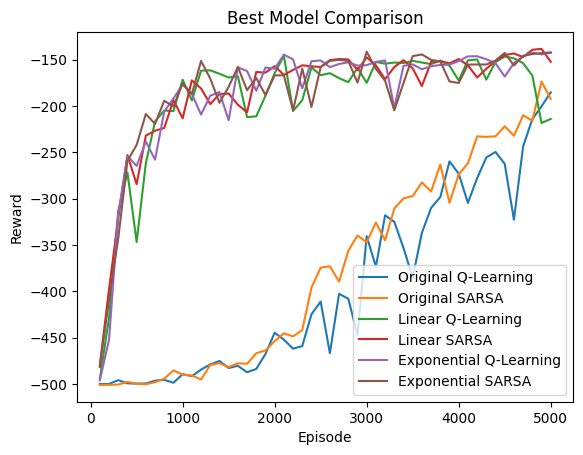

In [244]:
## Plotting
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), avg_rewardsQ5, label = 'Original Q-Learning')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), avg_rewardsS5, label = 'Original SARSA')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), best_avg_rewards_lineps, label = 'Linear Q-Learning')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), best_avg_rewards_linepsS, label = 'Linear SARSA')
plt.plot(100*(np.arange(len(avg_rewardsQ5)) + 1), best_avg_rewards_expeps, label = 'Exponential Q-Learning')
plt.plot(100*(np.arange(len(avg_rewardsS5)) + 1), best_avg_rewards_expepsS, label = 'Exponential SARSA')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title("Best Model Comparison")
plt.savefig("best")

In [246]:
#Q-learning exponential
print('Best reward: ',max(best_rewards_expeps) )
for i in np.arange(len(best_rewards_expeps)):
    if best_rewards_expeps[i] == max(best_rewards_expeps):
        print('On episode: ',i)


Best reward:  -84.0
On episode:  1900


In [248]:
# SARSA exponential
print('Best reward: ',max(best_rewards_expepsS))
for i in np.arange(len(best_rewards_expepsS)):
    if best_rewards_expepsS[i] == max(best_rewards_expepsS):
        print('On episode: ', i)

Best reward:  -96.0
On episode:  3833
On episode:  3840


In [249]:
# Q-learning linear
print('Best reward: ',max(best_rewards_lineps))
for i in np.arange(len(best_rewards_lineps)):
    if best_rewards_lineps[i] == max(best_rewards_lineps):
        print('On episode: ',i)

Best reward:  -105.0
On episode:  4531


In [250]:
# SARSA linear
print('Best reward: ',max(best_rewards_linepsS))

for i in np.arange(len(best_rewards_linepsS)):
    if best_rewards_linepsS[i] == max(best_rewards_linepsS):
        print('On episode: ',i)

Best reward:  -93.0
On episode:  1859
